In [1]:
import numpy as np
import matplotlib.pylab as plt
from pylab import *
import sys
from fft_utils import fft_1d, shift_1d


In [2]:
##########################
# define a few constants #		##fft python random phase
##########################

e0 = np.loadtxt('837nm.dat')		#load the reference pulse, pump @836 nm
e0 = e0.T
e1 = np.sqrt(e0[1])
e1_ph = e0[2]
e = np.array(e1)*np.exp(-1j*(np.array(e1_ph)))		#reforming E-field

original_trace = np.loadtxt('traces/trace11.frg')		#load FROG trace from experiment
N = len(e0[0])		#timesteps
N_max = np.max(e0[0])
N_min = np.min(e0[0])

t = e0[0]-N_min
T0 = N_max-N_min	#total time duration
dt = T0/(N-1)
df = 1.0/T0		#frequency steps
TD = N			#time delay for FROG-trace generation
freq = np.arange(0,1/dt+df,df)*1000


In [5]:
A = 3.0			#Amplitude of Raman pulse
a = 1.0			#intensity dependent factor ##it is not used in this program, ignore it.
a2 = 2.50*10**-6	#second order phase factor
a3 = 3.0*10**-9		#third order phase factor

f0 = 1.600/1000.0	#Raman center-wavelength
f1 = 0.25/1000.0	#Red-shifted center-wavelength

i0 = 333.0		#unit: fs
tau1 = T0/2+i0-400	#Raman pulse peak time
tau2 = tau1-700		#Red-shifted pulse peak time

In [6]:
## for generation of Gaussian pulses

def gaussian_pulse(T,f,A,phase,tau):
    w0 = f*2*np.pi		#central angular frequency of pulse
    temp = -1j*w0*(t-tau) + 1j*phase
    E = A*np.sqrt(np.exp(-4.0*np.log(2.0)/np.log(np.e)*((t-tau)/T)**2))*np.exp(-temp)
    return E

In [7]:

def xcorr(e0,e,td):		#shift one pulse by time delay of 'td'
    E_delay = e*1.0
    if td<=0:
        E_delay[0:N+td] = e0[-td:]
        E_delay[N+td:] = [0]*(-td)
        #E_delay=np.roll(e0,td)*([1]*(N+td)+[0]*(-td))
    else:
        E_delay[0:td] = [0]*(td)
        E_delay[td:] = e0[0:N-td]
        #E_delay=np.roll(e0,td)*([0]*(td)+[1]*(N-td))
    return  e*E_delay

In [8]:
def FROG_generator(e,E,TD):
    FROG = np.zeros((TD,N), dtype=np.float64)
    for td in range(-TD//2,TD//2):
        E_corre = xcorr(e,E,td)
       
        temp0 =np.fft.fftshift(np.fft.fft(E_corre))
        FROG[(td+TD//2)-1] = np.abs(temp0)**2
    return FROG.T

In [9]:
def array_difference(A,B):
	A = A/np.max(A)
	B = B/np.max(B)
	return np.sum(np.square(A-B))/np.sum(np.square(A))

In [10]:
def FROGs(t1,t2,i0,A,f0,a,a2,a3, f1, tau1, tau2): 
    phase1 = a2*np.power(t-tau1,2)+a3*np.power(t-tau1,3)
    phase2 = a2*(t-tau2)**2+a3*(t-tau2)**3
    E1 = gaussian_pulse(t1,f0,A,phase1,tau1)
    E2 = gaussian_pulse(t2,f1,a,phase2,tau2)
    E = E1+E2
    FROG = FROG_generator(e,E,TD)
    delta = array_difference(FROG, original_trace)
    return FROG, delta

In [11]:
def FROG_trace_plot(FROG):
    fig,ax = plt.subplots()
    plt.imshow(FROG)
    plt.title("FROG trace")
    plt.grid(True)
    plt.show()

In [12]:
def grads(t1, t2, i0, A, f0, a, a2, a3, f1, tau1, tau2):
    grad=np.zeros(11)
    epsilon=1e-9
    grad[0]=(FROGs(t1+epsilon,t2,i0,A,f0,a,a2,a3,f1, tau1,tau2)[1]-FROGs(t1-epsilon,t2,i0,A,f0,a,a2,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[1]=(FROGs(t1,t2+epsilon,i0,A,f0,a,a2,a3,f1, tau1,tau2)[1]-FROGs(t1,t2-epsilon,i0,A,f0,a,a2,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[2]=(FROGs(t1,t2,i0+epsilon,A,f0,a,a2,a3,f1, tau1,tau2)[1]-FROGs(t1,t2,i0-epsilon,A,f0,a,a2,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[3]=(FROGs(t1,t2,i0,A+epsilon,f0,a,a2,a3,f1, tau1,tau2)[1]-FROGs(t1,t2,i0,A-epsilon,f0,a,a2,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[4]=(FROGs(t1,t2,i0,A,f0+epsilon,a,a2,a3,f1, tau1,tau2)[1]-FROGs(t1,t2,i0,A,f0-epsilon,a,a2,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[5]=(FROGs(t1,t2,i0,A,f0,a+epsilon,a2,a3,f1, tau1,tau2)[1]-FROGs(t1,t2,i0,A,f0,a-epsilon,a2,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[6]=(FROGs(t1,t2,i0,A,f0,a,a2+epsilon,a3,f1, tau1,tau2)[1]-FROGs(t1,t2,i0,A,f0,a,a2-epsilon,a3, f1, tau1,tau2)[1])/(2*epsilon)
    grad[7]=(FROGs(t1,t2,i0,A,f0,a,a2,a3+epsilon*(10**-6),f1, tau1,tau2)[1]-FROGs(t1,t2,i0,A,f0,a,a2,a3-epsilon*(10**-6), f1, tau1,tau2)[1])/(2*epsilon*(10**-6))
    grad[8]=(FROGs(t1,t2,i0,A,f0,a,a2,a3, f1 + epsilon, tau1,tau2)[1]-FROGs(t1,t2,i0,A,f0,a,a2,a3, f1-epsilon, tau1,tau2)[1])/(2*epsilon)
    grad[9]=(FROGs(t1,t2,i0,A,f0,a,a2,a3, f1,tau1 + epsilon,tau2)[1]-FROGs(t1,t2,i0,A,f0,a,a2,a3, f1,tau1-epsilon,tau2)[1])/(2*epsilon)
    grad[10]=(FROGs(t1,t2,i0,A,f0,a,a2,a3, f1,tau1,epsilon+tau2)[1]-FROGs(t1,t2,i0,A,f0,a,a2,a3, f1,tau1, tau2-epsilon)[1])/(2*epsilon)
    return grad

In [13]:
def gradient_d(t1, t2, i0, A, f0, a, a2, a3, f1, tau1, tau2):
    learning_rate=np.array([10000, 10000, 0, .5, 1e-8, 0.05, 0, 0, 0.5, 50000,50000])
    epochs=500
    cost=[]
    for i in range(epochs):
        grad = grads(t1,t2,i0,A,f0,a,a2,a3 ,f1,tau1, tau2)
        t1 = t1 - learning_rate[0]*grad[0]
        t2 = t2 - learning_rate[1]*grad[1]
        #i0 = i0 - learning_rate[2]*grad[2]
        A = A - learning_rate[3]*grad[3]
        f0 = f0 - learning_rate[4]*grad[4]
        a = a - learning_rate[5]*grad[5]
        a2 = a2 - learning_rate[6]*grad[6]
        a3 = a3 - learning_rate[7]*grad[7]
        #f1 = f1 - learning_rate[8]*grad[8]
        tau1 = tau1 - learning_rate[9]*grad[9]
        tau2 = tau2 - learning_rate[10]*grad[10]
        (FROG, delta) = FROGs(t1,t2,i0,A,f0,a,a2,a3,f1, tau1, tau2) 
        print(i, delta)
        #print(delta, " t1 = ", grad[0], " t2 = ", grad[1], " A = ", grad[3], " f0 = ", grad[4]," a = ", grad[5], " a2 = ", grad[6], " a3 = ", grad[7], " f1 = ", grad[8])
        cost.append(delta)
        
    plt.plot(list(range(epochs)), cost, '-r') 
    plt.xlabel('Epochs') 
    plt.ylabel('Delta')
    print("T1=", t1,"\nT2 =",  t2,"\nA =", A,"\n f0 =",f0,"\n a =", a, "\n a2 =", a2,"\n a3 =", a3,"\n f1 =", f1,"\ntau1 =",tau1,"\ntau2 =", tau2)
    FROG_trace_plot(FROG)

0 0.6368322395050741
1 0.6148695590066141
2 0.5922292592549836
3 0.5660143833096659
4 0.5341008267079245
5 0.49830489548605394
6 0.45274312647416715
7 0.4007533227286906
8 0.3398979186048061
9 0.2756374344972028
10 0.2200343274855933
11 0.1850491255794673
12 0.17065870019919238
13 0.16573953289144316
14 0.16327468532258288
15 0.16140590629244125
16 0.1597827174878067
17 0.15831354614045676
18 0.15695373968145243
19 0.15567580322374322
20 0.1544614068597706
21 0.15329770825802572
22 0.15217627240482073
23 0.15109083508569857
24 0.15003702741675568
25 0.14901145286428263
26 0.1480117145561432
27 0.14703576889981834
28 0.14608195359828047
29 0.14514895809257103
30 0.14423558928701283
31 0.14334092470654614
32 0.14246447916561442
33 0.14160534589979412
34 0.14076273600739744
35 0.13993574507030576
36 0.13912380841874714
37 0.13832616273786905
38 0.13754230362141429
39 0.13677154363253977
40 0.13601332343210087
41 0.13526731748742396
42 0.13453279992111344
43 0.13380942148230993
44 0.133096

350 0.08763654628486477
351 0.08763623349792128
352 0.08763592723559972
353 0.08763562600601826
354 0.08763533039953529
355 0.08763504150288799
356 0.08763475736119851
357 0.0876344772527114
358 0.08763420358429908
359 0.08763393454514275
360 0.08763367059440473
361 0.08763341076791939
362 0.08763315648671592
363 0.0876329070039509
364 0.0876326616973347
365 0.08763242146118017
366 0.08763218610168623
367 0.0876319545509034
368 0.08763172765774438
369 0.08763150363936732
370 0.08763128404970681
371 0.0876310681112359
372 0.08763085650319226
373 0.0876306485115982
374 0.0876304447114962
375 0.08763024345826285
376 0.08763004579355643
377 0.08762985208552412
378 0.08762966152621404
379 0.08762947470932218
380 0.08762929153132966
381 0.08762911145880836
382 0.087628934271785
383 0.08762876014047005
384 0.08762858901911327
385 0.08762842158327314
386 0.08762825644827699
387 0.08762809379596619
388 0.08762793438891897
389 0.08762777779436819
390 0.08762762377287807
391 0.08762747122685599
3

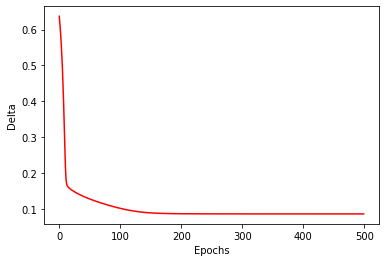

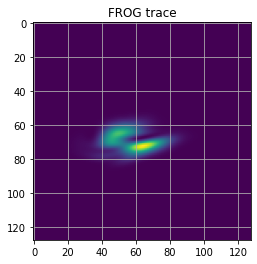

In [15]:
t1 = 500
t2 = 500
tau1=2902.965 
tau2=2202.965
gradient_d(t1, t2, i0, A, f0, a, a2, a3, f1, tau1, tau2)

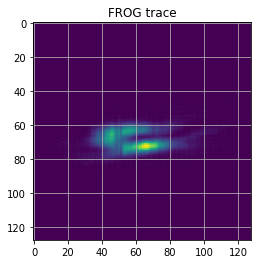

In [16]:
FROG_trace_plot(original_trace)